## sikp-gram模型

In [14]:
 import numpy as np

In [15]:
CONTEXT_SIZE = 2

text = """Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nunc eu sem 
scelerisque, dictum eros aliquam, accumsan quam. Pellentesque tempus, lorem ut 
semper fermentum, ante turpis accumsan ex, sit amet ultricies tortor erat quis 
nulla. Nunc consectetur ligula sit amet purus porttitor, vel tempus tortor 
scelerisque. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices 
posuere cubilia curae; Quisque suscipit ligula nec faucibus accumsan. Duis 
vulputate massa sit amet viverra hendrerit. Integer maximus quis sapien id 
convallis. Donec elementum placerat ex laoreet gravida. Praesent quis enim 
facilisis, bibendum est nec, pharetra ex. Etiam pharetra congue justo, eget 
imperdiet diam varius non. Mauris dolor lectus, interdum in laoreet quis, 
faucibus vitae velit. Donec lacinia dui eget maximus cursus. Class aptent taciti
sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Vivamus
tincidunt velit eget nisi ornare convallis. Pellentesque habitant morbi 
tristique senectus et netus et malesuada fames ac turpis egestas. Donec 
tristique ultrices tortor at accumsan.
""".split()

In [16]:
skipgrams = []
for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
    array = [text[j] for j in np.arange(i - CONTEXT_SIZE, i + CONTEXT_SIZE+1) if j != i]
    skipgrams.append((text[i],array))
print(skipgrams[0:2])

[('dolor', ['Lorem', 'ipsum', 'sit', 'amet,']), ('sit', ['ipsum', 'dolor', 'amet,', 'consectetur'])]


In [17]:
vocab = set(text)
VOCAB_SIZE = len(vocab)
print(VOCAB_SIZE)

121


In [18]:
from gensim.models.word2vec import Word2Vec

In [19]:
model = Word2Vec([text],
                 sg=1,
                 vector_size=10,
                 min_count=0,
                 window=2,
                 workers=2,
                 seed=0
                 )

In [20]:
print(model.wv.vectors.shape)

(121, 10)


In [21]:
model.train([text], total_examples=model.corpus_count, epochs=10)

(690, 1560)

## Deepwalk

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(0)

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


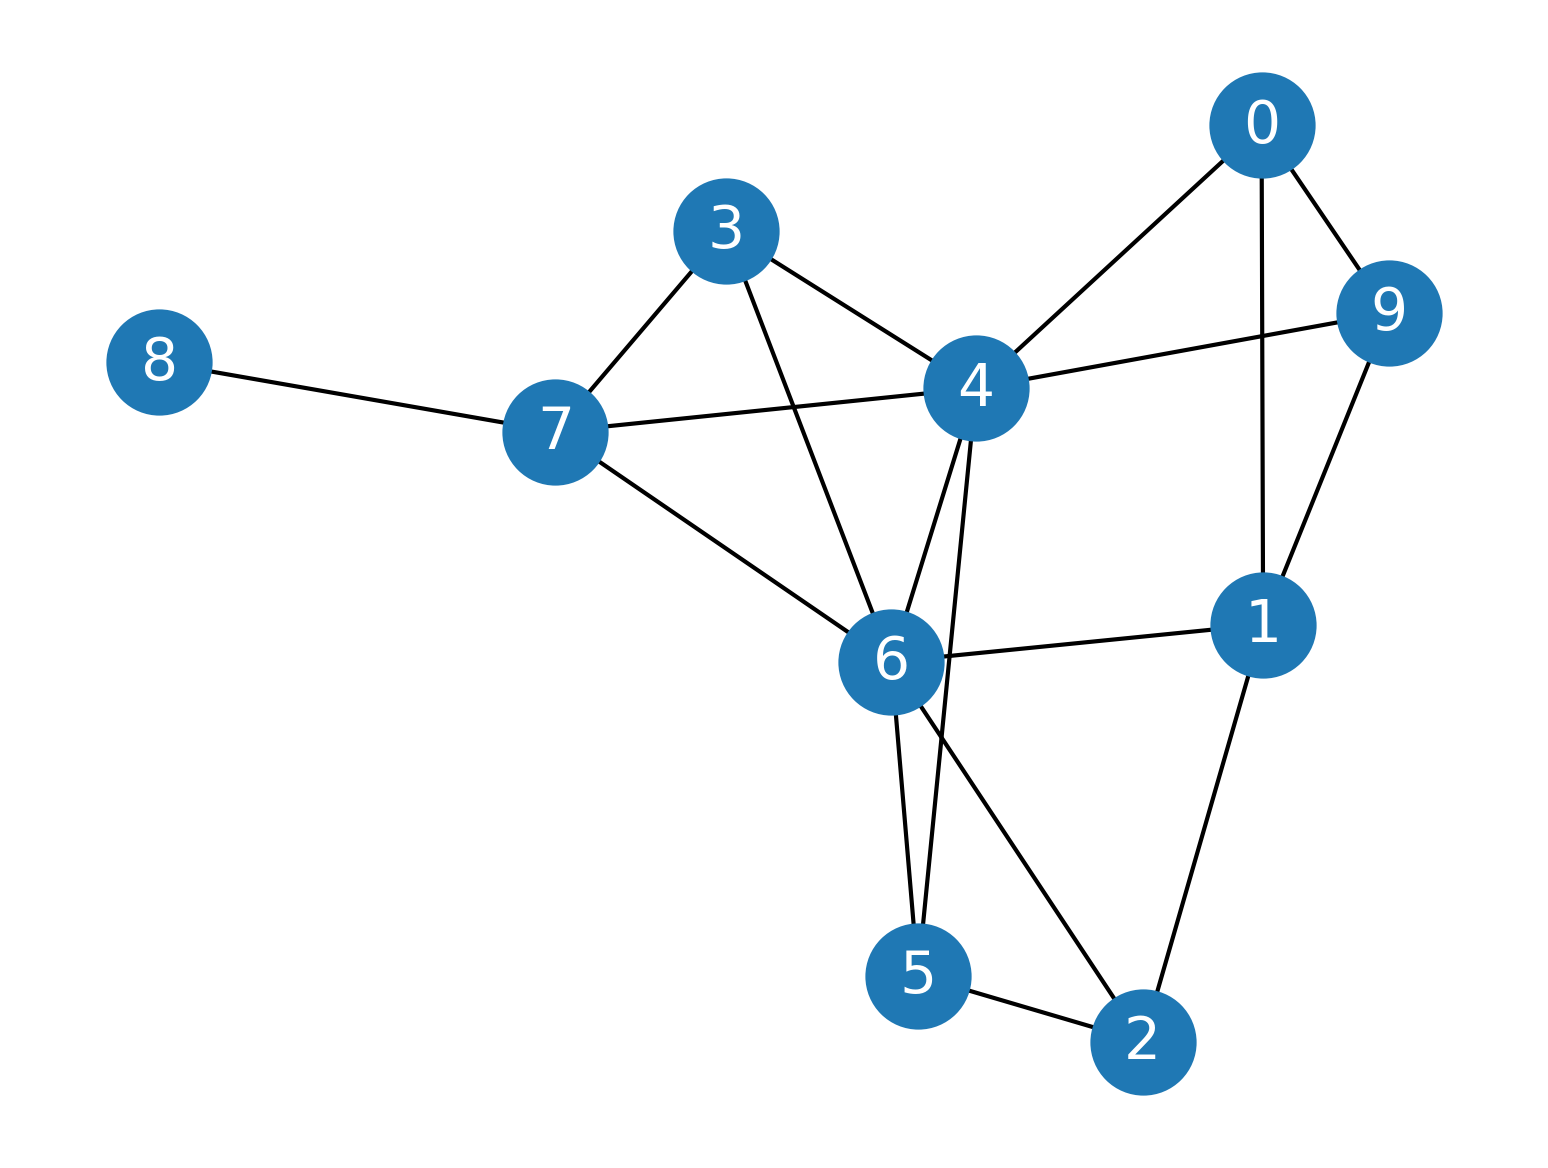

In [26]:
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)
plt.figure(dpi=300)
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white')

In [34]:
# 随机游走
def random_walk(start, length):
    walk = [str(start)]

    for i in range(length):
        neighbors = [node for node in G.neighbors(start)]
        next_node = np.random.choice(neighbors, 1)[0]
        walk.append(str(next_node))
        start = next_node

    return walk

In [35]:
print(random_walk(0, 10))

['0', '4', '9', '4', '9', '4', '3', '6', '7', '8', '7']


In [38]:
G = nx.karate_club_graph()
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


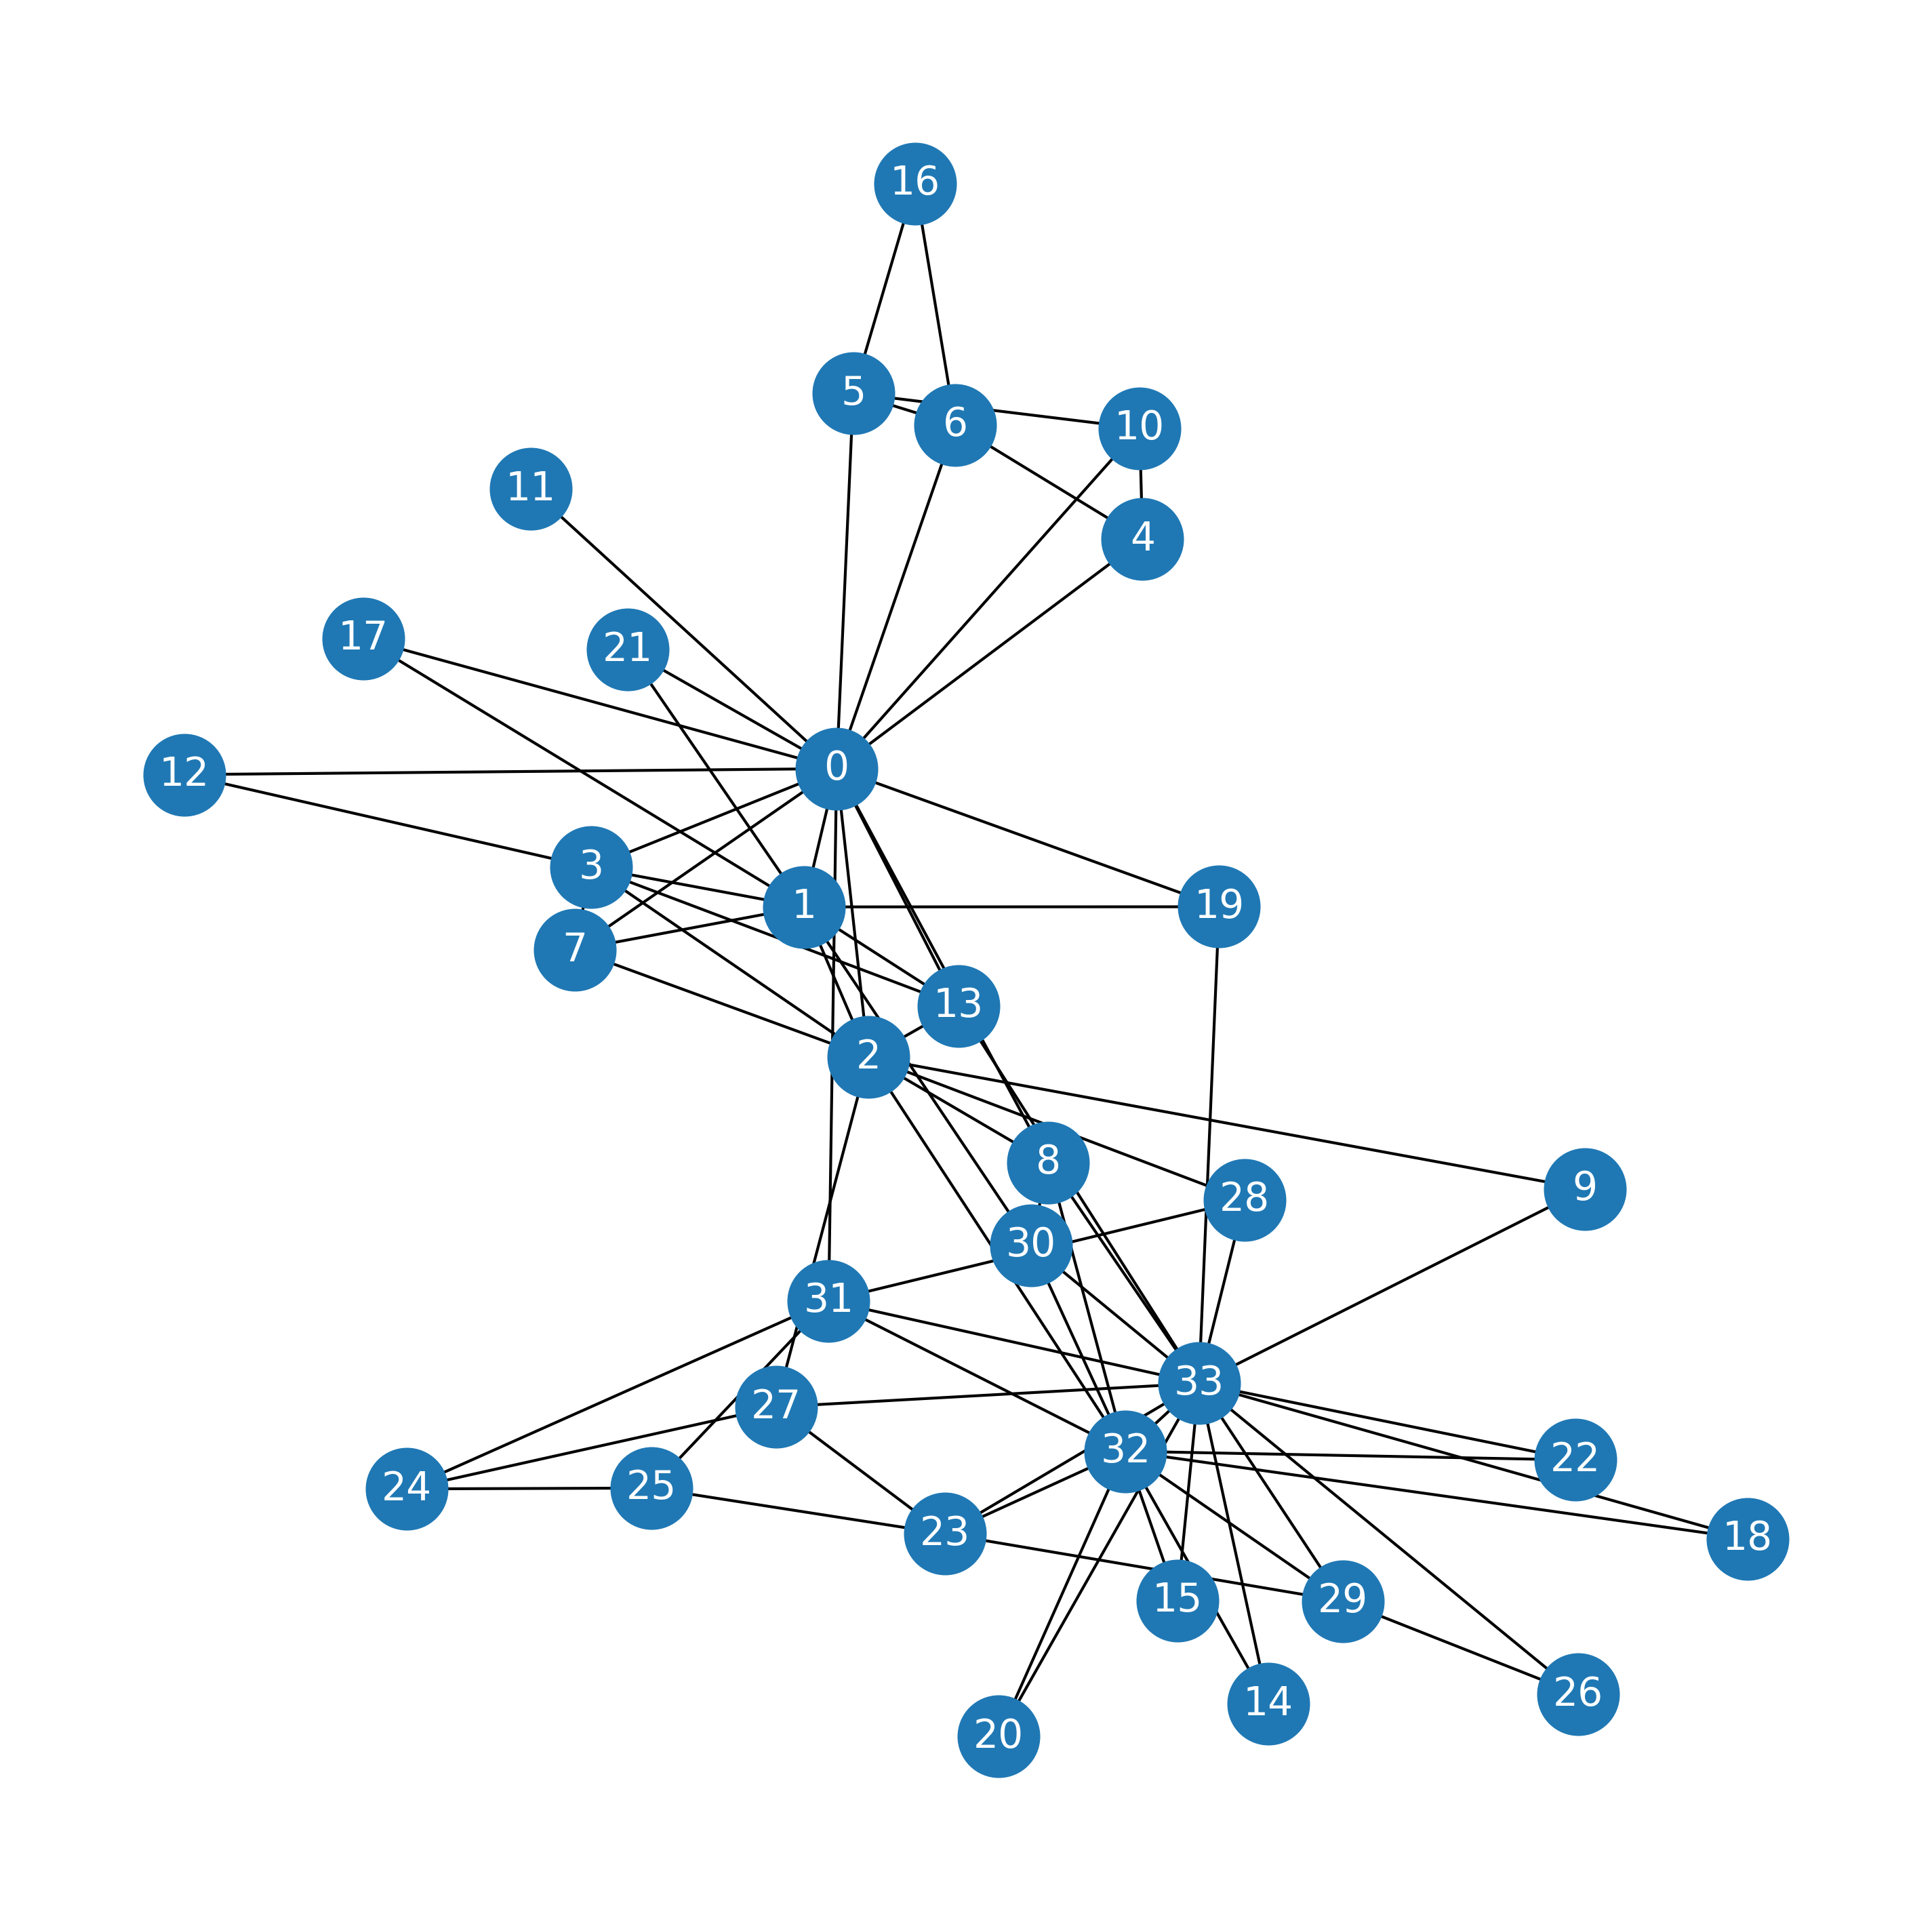

In [39]:
plt.figure(figsize=(12, 12),dpi=300)
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=800,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white')


In [40]:
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10))

In [41]:
print(walks[0:2])

[['0', '21', '1', '7', '3', '1', '17', '0', '11', '0', '10'], ['0', '21', '1', '2', '27', '2', '3', '0', '19', '33', '31']]


In [42]:
model = Word2Vec(walks,
                 hs=1,
                 sg=1,
                 vector_size=100,
                 window=10,
                 workers=2,
                 seed=0)
model.train(walks, total_examples=model.corpus_count, epochs=30, report_delay=1)

(186370, 897600)

In [44]:
for similarity in model.wv.most_similar(positive=['0']):
    print(similarity)

('4', 0.6750061511993408)
('17', 0.6727501749992371)
('10', 0.6458317041397095)
('21', 0.6197868585586548)
('11', 0.6183388829231262)
('5', 0.6107131838798523)
('6', 0.6022504568099976)
('12', 0.5895950198173523)
('3', 0.5825166702270508)
('7', 0.5268620848655701)


In [45]:
model.wv.similarity('0','4')

0.6750061

In [46]:
from sklearn.manifold import TSNE

In [48]:
nodes_wv = np.array([model.wv[str(i)] for i in range(G.number_of_nodes())])
range(len(model.wv))
labels = np.array(labels)

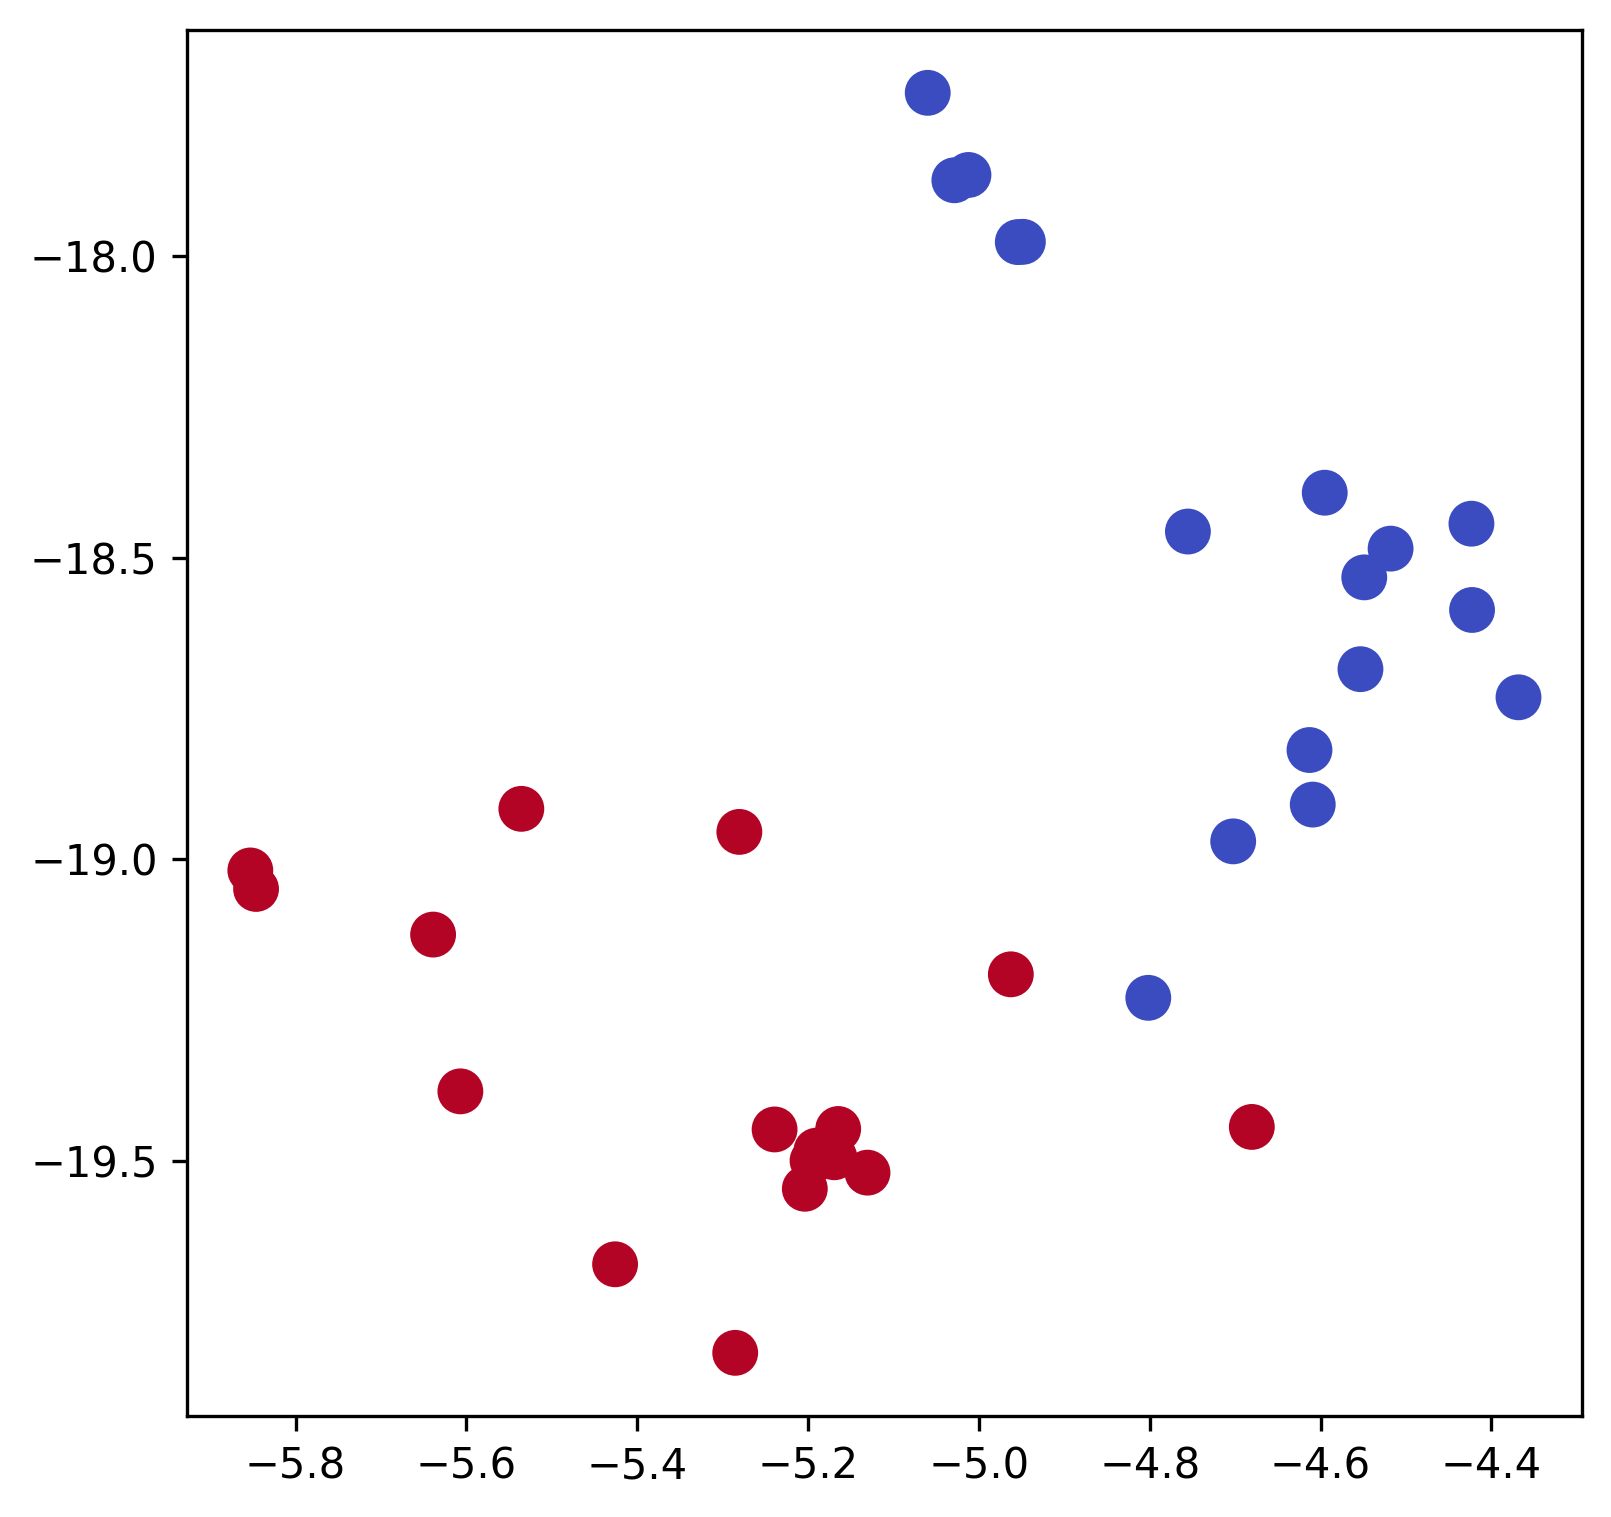

In [51]:
tsne = TSNE(n_components=2,
            learning_rate='auto',
            init='pca',
            random_state=0).fit_transform(nodes_wv)

plt.figure(figsize=(6, 6),dpi=300)
plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap='coolwarm', s=100)
plt.show()


In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [53]:
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]

In [55]:
clf = RandomForestClassifier(random_state=0)
clf.fit(nodes_wv[train_mask], labels[train_mask])
y_pred = clf.predict(nodes_wv[test_mask])
accuracy_score(labels[test_mask], y_pred)


0.8636363636363636